# Librerias:

In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.float_format='{:,.4f}'.format

# Cargando Archivos:

In [3]:
original_df = pd.read_excel('./data/original series.xlsx')
original_df = original_df.set_index('Date')

forecast_df = pd.read_excel('./data/series forecast.xlsx')
forecast_df = forecast_df.set_index('Date')

forecast_diff_df = pd.read_excel('./data/series forecast diff.xlsx')
forecast_diff_df = forecast_diff_df.set_index('Date')

with open('./data/impulse_responses.json', 'r') as f:
    impulse_response = json.load(f)

# Funciones:

In [4]:
def graficar(periodo_inicial):
    fig, ax = plt.subplots(figsize=(20,7))
    sns.lineplot(data=original_df['kW/h price mean'][periodo_inicial:], label='actual price')
    sns.lineplot(data=forecast_df['kW/h price ARIMA'], label='univariate model forecast')
    sns.lineplot(data=forecast_df['kW/h price SARIMAX'], label='multivariate model forecast')
    sns.lineplot(data=forecast_df['kW/h price Neural Prophet'], label='neural prohpet model forecast')
    sns.lineplot(data=forecast_df['kW/h price mean models'], label='mean forecast')
    fig.suptitle('kW/h price forecasting',fontsize=20)
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('kW/h price',fontsize=15)
    return plt.show()

In [5]:
def impulse_dataframe(date, var, expansion):
    impulse_dataframe = pd.DataFrame(impulse_response[var])*expansion
    impulse_dataframe['Date'] = pd.date_range(start=date, periods=len(impulse_response[var]), freq='D')
    impulse_dataframe['Date'] = pd.to_datetime(impulse_dataframe['Date'])
    impulse_dataframe.columns = ['price response','Date']
    impulse_dataframe = impulse_dataframe.set_index('Date')
    impulse_dataframe
    return impulse_dataframe

In [6]:
def response_dataframe(date, modelo, var, expansion):
    modelo = str(modelo)+' diff'
    temp_dataframe = pd.concat([forecast_diff_df[modelo], impulse_dataframe(date, var, expansion)], axis=1)
    temp_dataframe.columns = ['original', 'impulse']
    temp_dataframe = temp_dataframe.replace(np.nan, 0)
    temp_dataframe['response'] = temp_dataframe['original'] + temp_dataframe['impulse']
    return temp_dataframe

In [7]:
def original_level_after_shock(date, modelo, var, expansion):
    response = response_dataframe(date, modelo, var, expansion)['response'].tolist()
    origin = 83.2870833333333
    original_level_temp = []
    for i in range(0,len(response)):
        if i == 0:
            x = origin + response[0]
            original_level_temp.append(x)
        else:
            x = response[i] + original_level_temp[-1]
            original_level_temp.append(x)
    forecast_df = pd.DataFrame(original_level_temp)
    forecast_df['Date'] = pd.date_range(start='2021-07-15', periods=len(forecast_df), freq='D')
    forecast_df['Date'] = pd.to_datetime(forecast_df['Date'])
    forecast_df.columns = ['price response','Date']
    forecast_df = forecast_df.set_index('Date')
    return forecast_df

In [8]:
def simular_choque(periodo_inicial, date, modelo, var, expansion):
    fig, ax = plt.subplots(figsize=(20,7))
    sns.lineplot(data=original_df['kW/h price mean'][periodo_inicial:], label='actual price')
    sns.lineplot(data=forecast_df[modelo], label='model forecast')
    sns.lineplot(data=original_level_after_shock(date, modelo, var, expansion), palette='Greens')
    fig.suptitle('kW/h price forecasting',fontsize=20)
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('kW/h price',fontsize=15)
    return plt.show()

In [9]:
def response_con_convergencia(date, modelo, var, expansion):
    temp_dataframe = pd.concat([forecast_df[modelo], impulse_dataframe(date, var, expansion)], axis=1)
    temp_dataframe.columns = ['original', 'impulse']
    temp_dataframe = temp_dataframe.replace(np.nan, 0)
    temp_dataframe['response'] = temp_dataframe['original'] + temp_dataframe['impulse']
    return temp_dataframe

In [10]:
def original_level_after_shock_convergencia(date, modelo, var, expansion):
    response = response_con_convergencia(date, modelo, var, expansion)['response'].tolist()
    origin = 83.2870833333333
    original_level_temp = []
    for i in range(0,len(response)):
        if i == 0:
            x = response[0] #+ origin
            original_level_temp.append(x)
        else:
            x = response[i] #+ original_level_temp[-1]
            original_level_temp.append(x)
    forecast_df = pd.DataFrame(original_level_temp)
    forecast_df['Date'] = pd.date_range(start='2021-07-15', periods=len(forecast_df), freq='D')
    forecast_df['Date'] = pd.to_datetime(forecast_df['Date'])
    forecast_df.columns = ['price response','Date']
    forecast_df = forecast_df.set_index('Date')
    return forecast_df

In [11]:
def simular_choque_con_convergencia(periodo_inicial, date, modelo, var, expansion):
    fig, ax = plt.subplots(figsize=(20,7))
    sns.lineplot(data=original_df['kW/h price mean'][periodo_inicial:], label='actual price')
    sns.lineplot(data=forecast_df[modelo], label='model forecast')
    sns.lineplot(data=original_level_after_shock_convergencia(date, modelo, var, expansion), palette='Greens')
    fig.suptitle('kW/h price forecasting',fontsize=20)
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('kW/h price',fontsize=15)
    return plt.show()

# Graficas de las series:

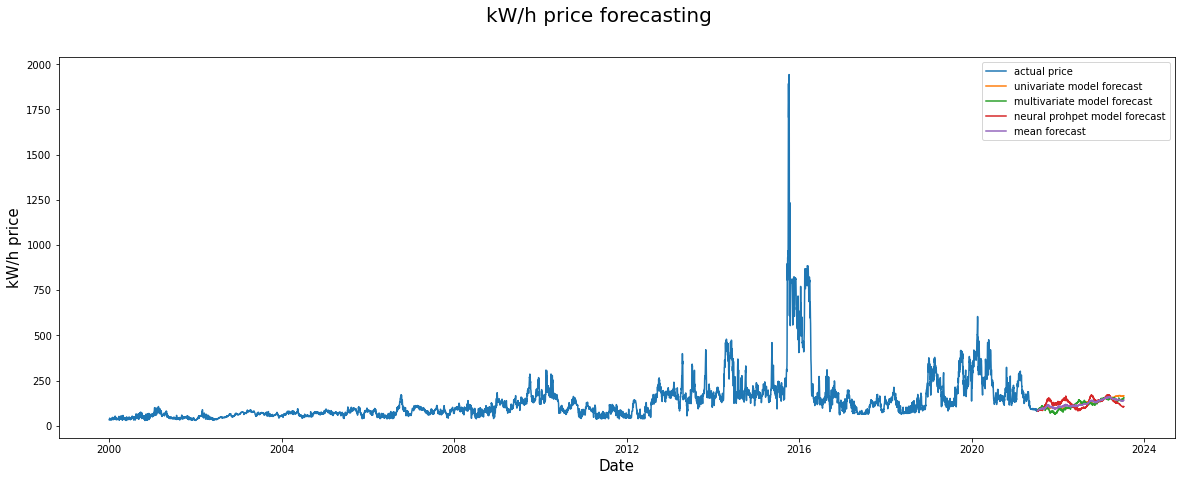

In [12]:
graficar(0)

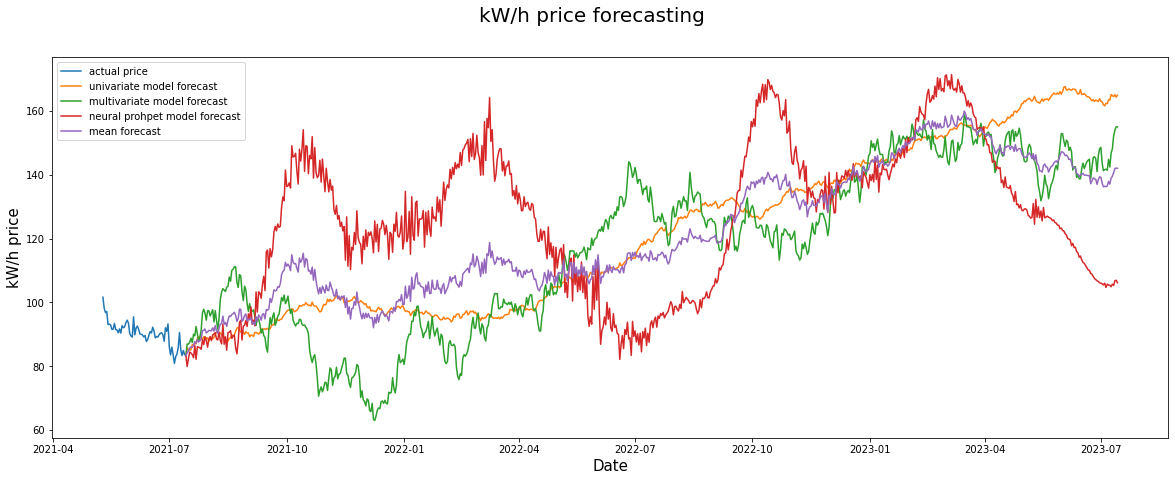

In [13]:
graficar(7800)

# Manual:

En el dashboard el usuario debe seleccionar:

0. Fecha inicio de la grafica
1. Fecha de choque
2. Modelo de forecasting
3. Definir si el choque es acumulativo o no
4. Variable que recibe el choque
5. Magnitud del choque
6. Definir si va con convergencia al forecasting o no

0. Fecha inicio: entero de 0 a 7865, donde 0 = '2000-01-01' y 7865 = '2021-07-14'
1. Fecha de choque: se ingresa de la forma **'2021-12-31'** tiene que ser mayor a '2021-07-14'
2. Modelo de forecasting, puede ser alguno de los siguientes: \
'kW/h price ARIMA', \
'kW/h price SARIMAX', \
'kW/h price Neural Prophet', \
'kW/h price mean models'.
3. Si el choque es acumulativo debe seleccionar una de las siguientes vairables: \
'Cumulative_HYDRAULIC availability', \
'Cumulative_THERMAL availability', \
'Cumulative_flow_contribution', \
'Cumulative_daily_volume_(Mm3)', \
'Cumulative_Volume_(Mm3)', \
'Cumulative_Daily_useful_Volume_(gWh)'
4. Si el choque no es acumulativo debe seleccionar una de las siguientes variables: \
'HYDRAULIC_availability' \
'THERMAL_availability' \
'flow_contribution' \
'daily_volume_(Mm3)' \
'Volume_(Mm3)' \
'Daily_useful_Volume_(gWh)'

5. Magnitud del choque es un entero, (explicacion por definir)
6. Si el choque es con convergencia al forecasting del modelo debe usar la funcion:  **simular_choque_con_convergencia()** \
si no es con convergencia aplica la funcion: **simular_choque()**

# Ejemplos:

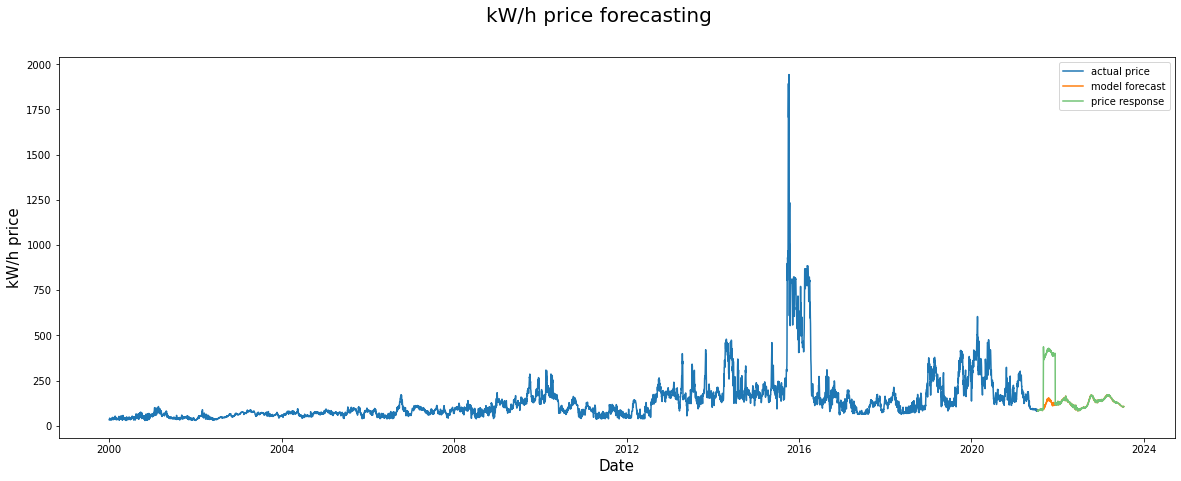

In [14]:
""" 
Choque con convergencia 
en la fecha '2022-01-15', 
en el modelo 'kW/h price Neural Prophet', 
sobre la variable 'Cumulative_HYDRAULIC availability'
de magnitud 100
"""
simular_choque_con_convergencia(0, '2021-08-31', 'kW/h price Neural Prophet', 'Cumulative_HYDRAULIC availability', -1000)

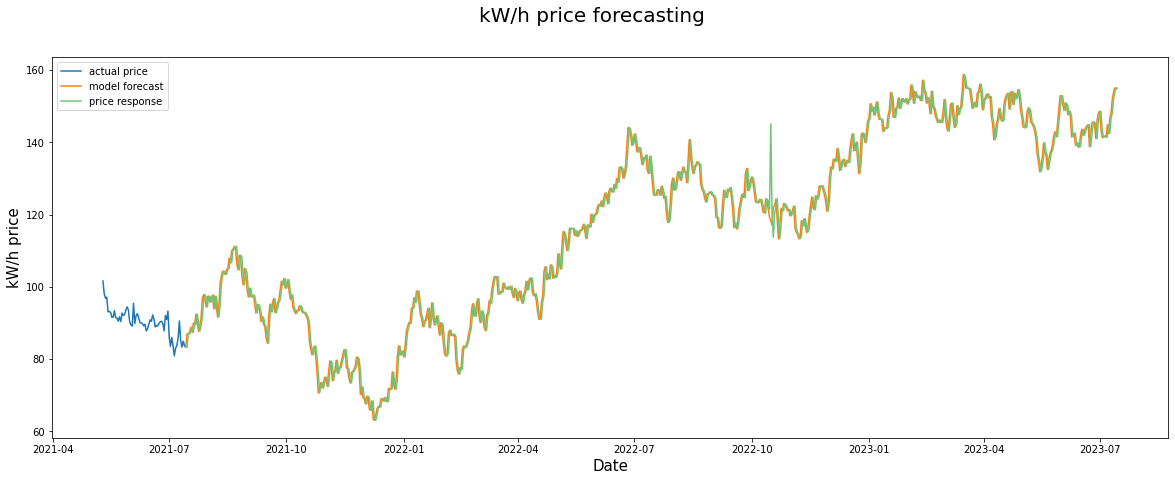

In [15]:
""" 
Choque con convergencia
en la fecha '2021-10-15', 
en el modelo 'kW/h price SARIMAX', 
sobre la variable 'HYDRAULIC_availability'
de magnitud -80
"""
simular_choque_con_convergencia(7800, '2022-10-15', 'kW/h price SARIMAX', 'HYDRAULIC_availability', -80)

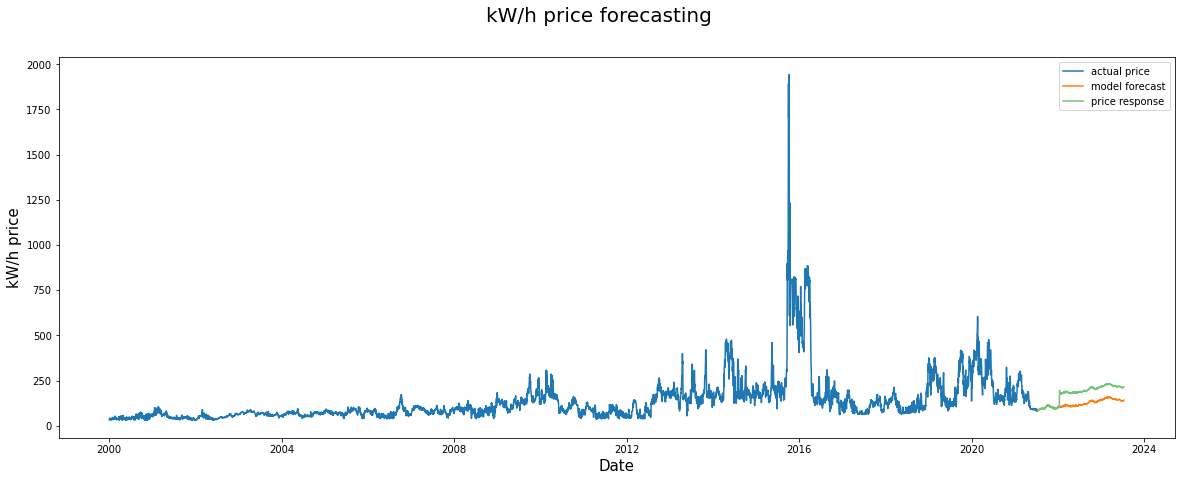

In [16]:
""" 
Choque sin convergencia
en la fecha '2021-10-15', 
en el modelo 'kW/h price mean models', 
sobre la variable 'THERMAL_availability'
de magnitud -800
"""
simular_choque(0, '2022-01-15', 'kW/h price mean models', 'THERMAL_availability', -800)

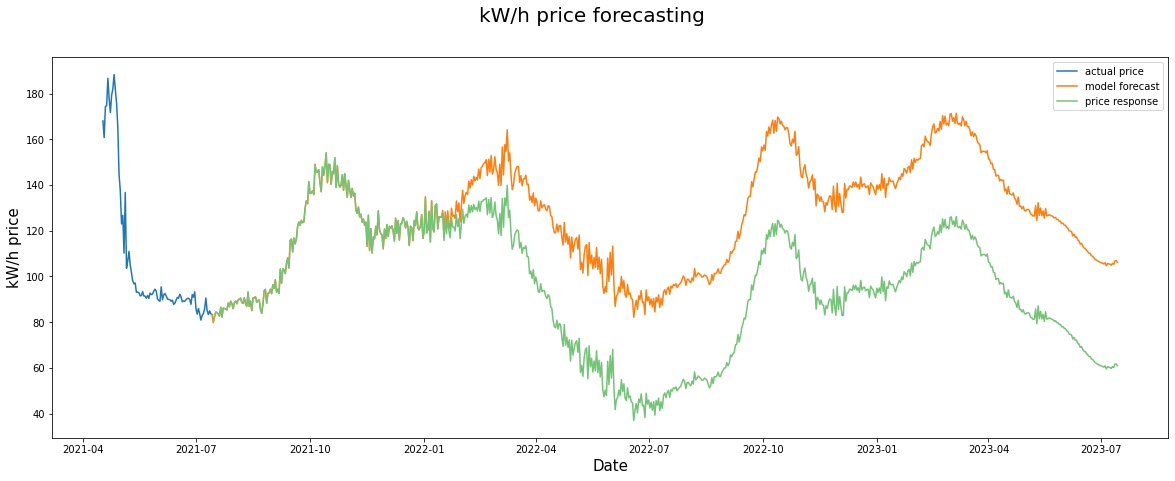

In [17]:
""" 
Choque sin convergencia
en la fecha '2021-10-15', 
en el modelo 'kW/h price Neural Prophet', 
sobre la variable 'Cumulative_Volume_(Mm3)'
de magnitud 8
"""
simular_choque(7777, '2022-01-15', 'kW/h price Neural Prophet', 'Cumulative_Volume_(Mm3)', -8)

In [18]:
def comparar_resultados(df_1,df_2):
    temp_comp = pd.concat([df_1,df_2], axis =1)
    temp_comp.columns = ['forecast','impulse']
    temp_comp['variation'] = ((temp_comp['impulse'] - temp_comp['forecast']) / temp_comp['forecast']) * 100
    return temp_comp